📓 Análise de Imagem de Túnel por Setores

Este notebook realiza a análise setorial de uma imagem de túnel, classificando cada setor em proporções de:


🌌 Céu

🛣️ Pavimento

🪨 Rochas

🏢 Edifícios

🌿 Matas

🚇 Túnel

Os resultados são exportados para um CSV.

In [1]:
pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 954.2 kB/s eta 0:00:41
    --------------------------------------- 0.5/39.0 MB 954.2 kB/s eta 0:00:41
    --------------------------------------- 0.8/39.0 MB 900.5 kB/s eta 0:00:43
   - -------------------------------------- 1.0/39.0 MB 989.3 kB/s eta 0:00:39
   - -------------------------------------- 1.3/39.0 MB 1.0 MB/s eta 0:00:38
   - -------------------------------------- 1.8/39.0 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.1/39.0 MB 1.3 MB/s eta 0:00:30
   -- ------------------------------------- 2.4/39.0 MB 1.2 MB/s eta 0:00:30
   -- ------------------------------------- 2.6/39.0 MB 1.2 MB/s eta 0:00:30
   -- ------------------------------------- 2.9/39.0 MB 1.3 MB/s eta 0:00:29
   --- -----

In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [81]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


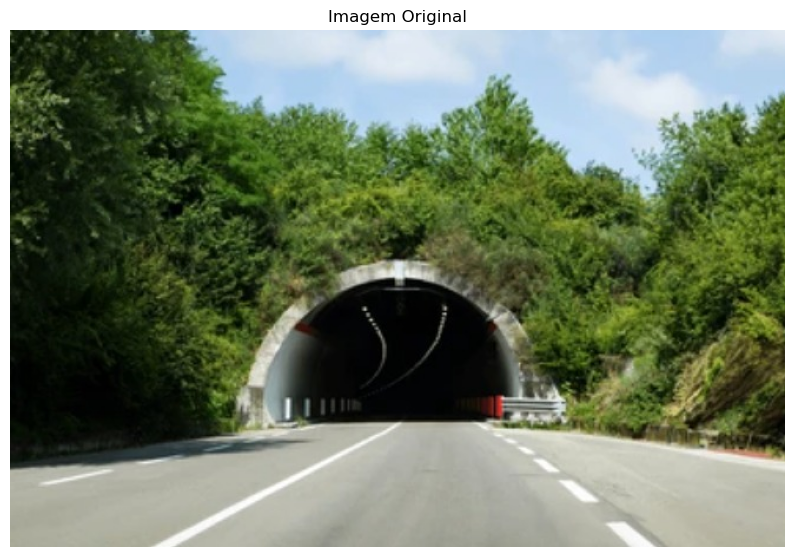

In [183]:
# Caminho da imagem
img_path = "WhatsApp Image 2025-09-29 at 12.12.18.jpeg"

# Carregar imagem em RGB
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape


h_camera = 1.5  # altura da câmera em metros
altura_visivel = 5.0  # altura total visível da cena em metros

x_center = w // 2
y_center = int(h - (h_camera / altura_visivel) * h)
center = (x_center, y_center)

# Parâmetros dos setores
num_setores = 12
distancia_tunel = 200  # distância até o túnel em metros

angulos_graus = [2.0, 3.0, 4.0, 5.8, 8.0, 11.6, 16.6, 24.0, 36.0, 56.8]
lista_angulos = np.radians(angulos_graus)

# Calcular 12 raios concêntricos a partir do cateto adjacente
lista_raios = [distancia_tunel * np.tan(theta) for theta in lista_angulos]

# Mostrar imagem
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Imagem Original")
plt.axis("off")
plt.show()

In [184]:
print(lista_angulos)

[0.03490659 0.05235988 0.06981317 0.1012291  0.13962634 0.20245819
 0.28972466 0.41887902 0.62831853 0.99134702]


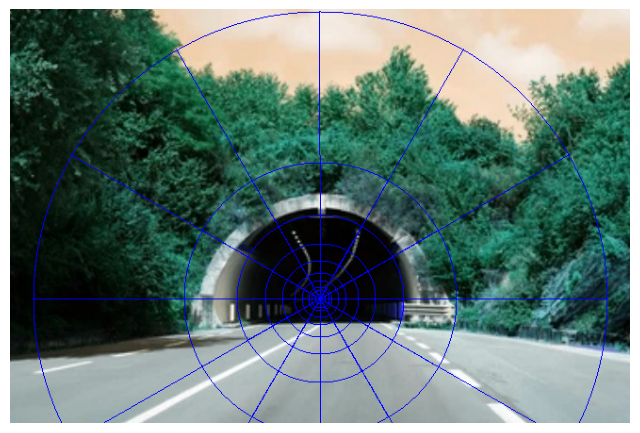

In [185]:
def desenhar_setores(img, center, lista_raios, num_setores, cor=(255,0,0), espessura=1):
    img_draw = img.copy()

    # Filtrar raios muito grandes (maiores que a diagonal da imagem não fazem sentido)
    max_raio = int(np.sqrt(img.shape[0]**2 + img.shape[1]**2))
    lista_raios_filtrada = [int(min(r, max_raio)) for r in lista_raios if np.isfinite(r) and r > 0]

    # Desenha círculos concêntricos
    for raio in lista_raios_filtrada:
        cv2.circle(img_draw, center, raio, cor, espessura)

        # Desenha linhas radiais
        for j in range(num_angulos):
            ang = 2 * np.pi * j / num_angulos
            x = int(center[0] + raio * np.cos(ang))
            y = int(center[1] + raio * np.sin(ang))
            cv2.line(img_draw, center, (x, y), cor, espessura)

    return img_draw


img_setores = desenhar_setores(img, center, lista_raios, num_angulos)

# Mostrar imagem usando matplotlib
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_setores, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

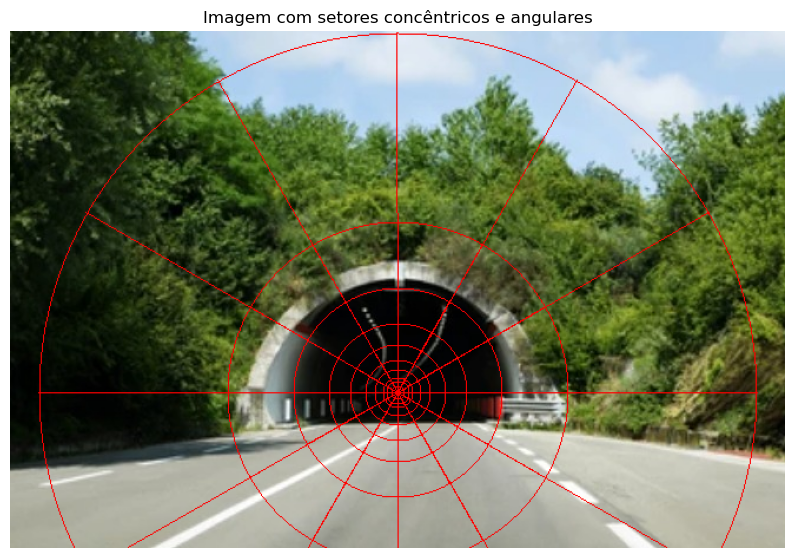

In [186]:
def gerar_setores_conc_ang(h, w, center, lista_raios, num_angulos):
    """
    Gera setores concêntricos e angulares a partir de um ponto central.

    h, w           -> dimensões da imagem
    center         -> ponto central (x, y)
    lista_raios    -> lista de raios [r1, r2, r3,...] para círculos/coroas
    num_angulos    -> número de divisões angulares por coroa
    """
    setores = []  # precisa inicializar
    Y, X = np.ogrid[:h, :w]
    dx, dy = X - center[0], Y - center[1]

    R = np.sqrt(dx**2 + dy**2)  # distância de cada pixel até o centro
    Theta = (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)  # ângulo polar [0, 2pi)

    raio_in = 0
    for raio_out in lista_raios:
        for j in range(num_angulos):
            ang_in = 2 * np.pi * j / num_angulos
            ang_out = 2 * np.pi * (j+1) / num_angulos

            mask = (R > raio_in) & (R <= raio_out) & (Theta >= ang_in) & (Theta < ang_out)
            setores.append(mask.astype(np.uint8))

        raio_in = raio_out

    return setores

# Visualizar
img_setores = desenhar_setores(img, center, lista_raios, num_angulos)

plt.figure(figsize=(10,10))
plt.imshow(img_setores)
plt.title("Imagem com setores concêntricos e angulares")
plt.axis("off")
plt.show()

HSV é a abreviatura para o sistema de cores formadas pelas componentes hue (matiz), saturation (saturação) e value (valor). O HSV também é conhecido como HSB (hue, saturation e brightness — matiz, saturação e brilho, respectivamente). Esse sistema de cores define o espaço de cor conforme descrito abaixo, utilizando seus três parâmetros:

Matiz (tonalidade): Verifica o tipo de cor, abrangendo todas as cores do espectro, desde o vermelho até o violeta, mais o magenta. Atinge valores de 0 a 360, mas para algumas aplicações, esse valor é normalizado de 0 a 100%.
Saturação: Também chamado de "pureza". Quanto menor esse valor, mais com tom de cinza aparecerá a imagem. Quanto maior o valor, mais "pura" é a imagem. Atinge valores de 0 a 100%.
Valor (brilho): Define o brilho da cor. Atinge valores de 0 a 100%.

In [302]:
def classificar_pixel(h, s, v):
    """
    Classifica um pixel em uma das categorias:
    🌌 Céu
    🛣️ Pavimento
    🪨 Rochas
    🏢 Edifícios
    🌿 Matas
    🚇 Túnel
    """

def classificar_pixel(h, s, v):
    # Céu: tons claros e pouco saturados (azul claro, céu diurno)
    if (h >= 90 and h <= 130) and v > 150 and s < 80:
        return "ceu"
    
    # Pavimento: tons claros de cinza, baixa saturação
    elif 60 <= v < 180 and s < 50:  # ajustado para pegar tons mais claros
        return "pavimento"
    
    # Rochas: tons acastanhados, cinza ou bege
    elif (0 <= h <= 40 or 20 <= h <= 30) and s > 30 and v > 80:
        return "rochas"
    
    # Edifícios: geralmente cinza/escuro, saturação média
    elif s < 60 and 50 < v < 180:
        return "edificios"
    
    # Vegetação/matas: tons de verde
    elif 35 <= h <= 85 and s > 40 and v > 50:
        return "matas"
    
    # Túnel: muito escuro, pouco saturado
    elif v < 50:
        return "tunnel"
    
    else:
        return "desconhecido"


In [303]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
resultados = []
setores = gerar_setores_conc_ang(h, w, center, lista_raios,num_angulos)
print(len(setores))  # Ex.: 9 raios * 12 ângulos = 108 setores

for idx, mask in enumerate(setores):
    pixels = hsv_img[mask == 1]
    if len(pixels) == 0:
        continue
    
    # Classificar todos os pixels de uma vez
    classes = [classificar_pixel(h, s, v) for h, s, v in pixels]
    total = len(classes)

    # Contagem relativa para todas as categorias
    categorias = set(classes)
    contagens = {"setor": idx}
    for cat in set(classes):
        contagens[cat] = classes.count(cat) / total * 100  # % de pixels por categoria

    # Calcula anel e segmento
    contagens['anel'] = (idx // num_angulos)        # de dentro para fora
    contagens['segmento'] = (idx % num_angulos) + 1    # sentido horário

    resultados.append(contagens)

df = pd.DataFrame(resultados).fillna(0)

# Mantém só a partir da linha 12 em diante
df = df.iloc[12:].reset_index(drop=True)
print(df.shape)  # deve ser (108, N) se forem 108 setores



120
(108, 10)


In [304]:
output_csv = "analise_tunel.csv"
df.to_csv(output_csv, index=False,float_format="%.2f")
print(f"CSV salvo em: {output_csv}")

df.head(24)



CSV salvo em: analise_tunel.csv


,setor,tunnel,anel,segmento,edificios,desconhecido,pavimento,rochas,matas,ceu
0,12,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,13,100.0,1,2,0.0,0.0,0.0,0.0,0.0,0.0
2,14,100.0,1,3,0.0,0.0,0.0,0.0,0.0,0.0
3,15,100.0,1,4,0.0,0.0,0.0,0.0,0.0,0.0
4,16,100.0,1,5,0.0,0.0,0.0,0.0,0.0,0.0
5,17,100.0,1,6,0.0,0.0,0.0,0.0,0.0,0.0
6,18,100.0,1,7,0.0,0.0,0.0,0.0,0.0,0.0
7,19,100.0,1,8,0.0,0.0,0.0,0.0,0.0,0.0
8,20,100.0,1,9,0.0,0.0,0.0,0.0,0.0,0.0
9,21,100.0,1,10,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
df = df.round(2)  # arredonda todas as colunas numéricas para 2 casas decimais
df.to_csv("resultado_setores.csv", index=False)

In [306]:
df.tail(24)

,setor,tunnel,anel,segmento,edificios,desconhecido,pavimento,rochas,matas,ceu
84,96,1.03,8,1,0.66,54.94,24.18,16.71,1.72,0.75
85,97,0.00,8,2,0.00,27.23,72.77,0.00,0.00,0.00
86,98,0.00,8,3,0.00,0.00,100.00,0.00,0.00,0.00
87,99,0.00,8,4,0.00,3.45,96.55,0.00,0.00,0.00
88,100,0.00,8,5,0.00,89.46,10.54,0.00,0.00,0.00
89,101,1.46,8,6,1.69,33.04,43.23,15.82,2.16,2.60
90,102,0.89,8,7,0.03,18.58,31.94,32.91,12.78,2.87
91,103,16.63,8,8,0.52,11.47,4.84,45.10,21.44,0.00
92,104,15.85,8,9,0.44,13.16,10.42,31.29,28.52,0.32
93,105,21.31,8,10,0.63,11.66,12.95,43.45,8.79,1.21


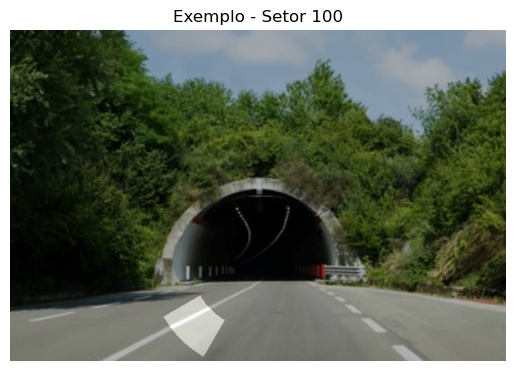

In [307]:
# Visualizar um exemplo de setor aplicado na imagem
setor_exemplo =100



mask_rgb = np.dstack([setores[setor_exemplo]*255]*3)
overlay = cv2.addWeighted(img, 0.7, mask_rgb, 0.3, 0)

plt.imshow(overlay)
plt.title(f"Exemplo - Setor {setor_exemplo}")
plt.axis("off")
plt.show()


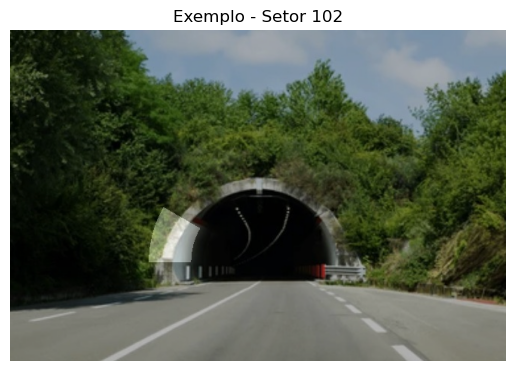

In [308]:
# Visualizar um exemplo de setor aplicado na imagem
setor_exemplo =102



mask_rgb = np.dstack([setores[setor_exemplo]*255]*3)
overlay = cv2.addWeighted(img, 0.7, mask_rgb, 0.3, 0)

plt.imshow(overlay)
plt.title(f"Exemplo - Setor {setor_exemplo}")
plt.axis("off")
plt.show()


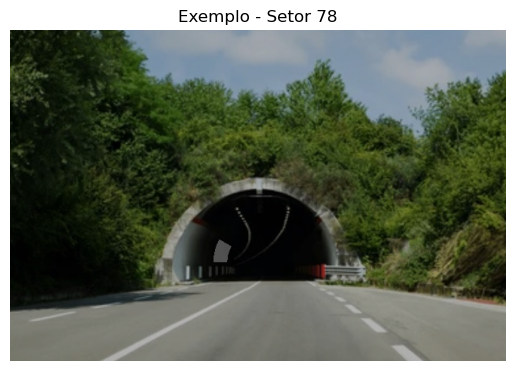

In [309]:
# Visualizar um exemplo de setor aplicado na imagem
setor_exemplo =102-24



mask_rgb = np.dstack([setores[setor_exemplo]*255]*3)
overlay = cv2.addWeighted(img, 0.7, mask_rgb, 0.3, 0)

plt.imshow(overlay)
plt.title(f"Exemplo - Setor {setor_exemplo}")
plt.axis("off")
plt.show()


In [310]:
# Seleciona todos os pixels da imagem (ou de todos os setores, se quiser)
pixels = hsv_img.reshape(-1, 3)  # todos os pixels da imagem

# Classifica cada pixel
classes = [classificar_pixel(h, s, v) for h, s, v in pixels]
total = len(classes)

# Contagem relativa por categoria
contagens = {}
for cat in set(classes):
    contagens[cat] = classes.count(cat) / total * 100  # % de pixels por categoria

# Cria DataFrame de uma linha
df_total = pd.DataFrame([contagens])
print(df_total)

   edificios     tunnel     rochas        ceu  desconhecido      matas  \
0    0.76611  24.185251  14.504158  13.679196     14.512812  21.353449   

   pavimento  
0  10.999024  


In [311]:
# Dicionário com cores RGB para cada categoria
cores = {
    "ceu": (135, 206, 235),         # azul claro
    "pavimento": (128, 128, 128),   # cinza
    "rochas": (139, 69, 19),        # marrom
    "edificios": (105, 105, 105),   # cinza escuro
    "matas": (34, 139, 34),         # verde
    "tunnel": (0, 0, 0),            # preto
    "desconhecido": (255, 0, 255)   # magenta
}


In [312]:
# Criar um array vazio da mesma forma da imagem
img_segmentada = np.zeros_like(img)  # RGB

# Achatar a imagem para iterar nos pixels
pixels_hsv = hsv_img.reshape(-1, 3)

# Classificar pixels
classes = [classificar_pixel(h, s, v) for h, s, v in pixels_hsv]

# Mapear cores
for i, cls in enumerate(classes):
    img_segmentada.reshape(-1, 3)[i] = cores.get(cls, (255, 0, 255))  # magenta se desconhecido

# Reshape para o tamanho original da imagem
img_segmentada = img_segmentada.reshape(img.shape)


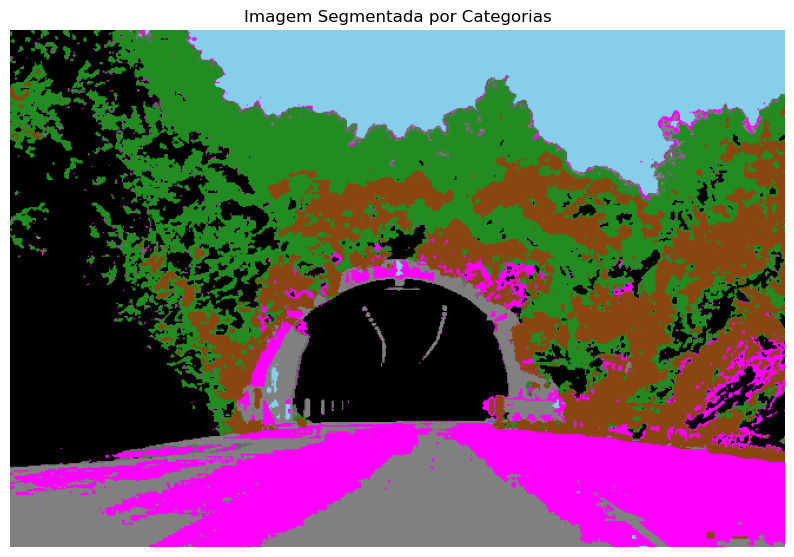

In [313]:
plt.figure(figsize=(10,10))
plt.imshow(img_segmentada)
plt.title("Imagem Segmentada por Categorias")
plt.axis("off")
plt.show()
